# First Steps: N=2

Author(s): Kyle Godbey

Maintainer: Kyle Godbey

TODO: write some background on the interaction/hamiltonian, how and why we convert it to a pauli representation

We begin with...

Now let's set up our imports! For this first example and the next we will just use [pennylane](https://pennylane.ai/) and define the circuits and Hamiltonian directly in the form from [Cloud Quantum Computing of an Atomic Nucleus](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.210501).

In [1]:
%matplotlib inline

from qiskit import *
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
import warnings
warnings.filterwarnings('ignore')

Now we will define our 'device' (a simulator in this case) as well as our ansatz and Hamiltonian.

In [2]:
# In this case we just need 2 qubits

dev = qml.device("default.qubit", wires=2)

# Defining our ansatz circuit for the N=2 case

def circuit(params,wires):
    t0 = params[0]
    qml.PauliX(wires=0)
    qml.RY(t0, wires=1)
    qml.CNOT(wires=[1,0])

# And building our Hamiltonian for the N=2 case

coeffs = [5.906709, 0.218291, -6.125, -2.143304, -2.143304]
obs = [qml.Identity(0), qml.PauliZ(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1), qml.PauliY(0) @ qml.PauliY(1)]

H = qml.Hamiltonian(coeffs, obs)
cost_fn = qml.ExpvalCost(circuit, H, dev)

# Let's print it out
print(H)

  (-6.125) [Z1]
+ (0.218291) [Z0]
+ (5.906709) [I0]
+ (-2.143304) [X0 X1]
+ (-2.143304) [Y0 Y1]


Great! That's a good looking Hamiltonian, even if it was a bit tedious to write it out. We'll find out a more programmatic way to do it later, but for now let's move on to the fun stuff.

Now we'll set up what we'll need for the VQE procedure; namely some initial parameters and convergence info. You can select the initial guess randomly, but in this case we'll set it manually for repeatability.

In [3]:
# Our parameter array, only one lonely element in this case :c

init_params = np.array([2.5,])

# Convergence information and step size

max_iterations = 500
conv_tol = 1e-06
step_size = 0.01

Finally, the VQE block. A lot of the stuff in this block is bookkeeping -- the real magic happens in the `opt` object that contains an built-in optimizer. You can have a look at the documentation and change this if you like, but we'll also have a look at this later.

In [4]:
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params

gd_param_history = [params]
gd_cost_history = []

for n in range(max_iterations):

    # Take a step in parameter space and record your energy
    params, prev_energy = opt.step_and_cost(cost_fn, params)

    # This keeps track of our energy for plotting at comparisons
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    # Here we see what the energy of our system is with the new parameters
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} MeV,  Convergence parameter = {"
            ":.8f} MeV".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} MeV".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 7.89426366 MeV,  Convergence parameter = 0.52891694 MeV
Iteration = 20,  Energy = -0.66950925 MeV,  Convergence parameter = 0.17005461 MeV
Iteration = 40,  Energy = -1.70101182 MeV,  Convergence parameter = 0.00828148 MeV
Iteration = 60,  Energy = -1.74716419 MeV,  Convergence parameter = 0.00034480 MeV
Iteration = 80,  Energy = -1.74907865 MeV,  Convergence parameter = 0.00001426 MeV

Final value of the energy = -1.74915572 MeV
Number of iterations =  97


Not too bad! Well, it's a far cry from the true, real-life binding energy of the deuteron, but it's a start! You can have a look at the paper linked above and find some tricks to extrapolate to the true value. 

But just looking at the VQE result, if you compare this to the value reported in the paper you'll see that we match their value very well, which is encouraging.

Let's plot the convergence next.

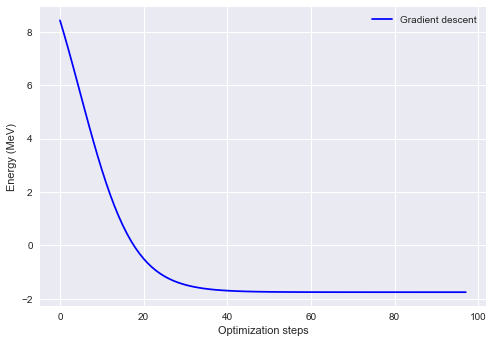

In [5]:
plt.style.use("seaborn")
plt.plot(gd_cost_history, "b", label="Gradient descent")

plt.ylabel("Energy (MeV)")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Finally, we can plot how we trace the potential energy surface (PES) as we find a solution. For this 1-D case it's not as interesting, but it might hint at how you can improve performance.

If you're running this yourself, you can either generate the surface yourself or put this code in a cell to download it locally:

`!wget github.com/kylegodbey/nuclear-quantum-computing/...`

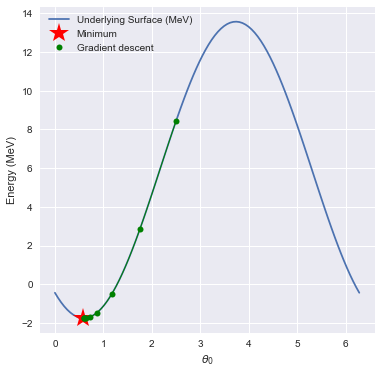

In [6]:
# Discretize the parameter space
theta0 = np.linspace(0.0, 2.0 * np.pi, 100)

# Load energy value at each point in parameter space
pes = np.load("deut_pes_n2.npy")

# Get the minimum of the PES
minloc=np.unravel_index(pes.argmin(),pes.shape)

# Plot energy landscape
fig, axes = plt.subplots(figsize=(6, 6))

plt.plot(theta0,pes[:,0],label="Underlying Surface (MeV)")

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"Energy (MeV)")
plt.plot(theta0[minloc[0]],cost_fn([theta0[minloc[0]],]),"r*",markersize=20,label="Minimum")

# Plot optimization path for gradient descent. Plot every 10th point.
gd_color = "g"

plt.plot(
    np.array(gd_param_history)[::10, 0],
    np.array(gd_cost_history)[::10],
    ".",markersize=12,
    color=gd_color,
    linewidth=2,
    label="Gradient descent",
)
plt.plot(
    np.array(gd_param_history)[:-1, 0],
    np.array(gd_cost_history)[:],
    "-",
    color=gd_color,
    linewidth=1,
)


plt.legend()
plt.show()

Perfect! Now that you've got this working, you can go back and play around with the parameters of the VQE, potential, initial guesses, etc. and see how your convergence changes! When it comes to running on real hardware for serious problems, one key goal is to get the number of evaluations as low as possible. This is an even bigger deal for larger circuits, like the N=3 case we'll look at next!

---

## Error mitigation with ZNE

As hinted at already, what if we wanted to run this on a real device? We're definitely going to encounter some error in our quantum circuit. Let's try to mitigate it by runnning __zero-noise extrapolation (ZNE)__. We'd like to refrain from running this on a real device immediately, so let's try using a backend with a noise model that simulates the type of noise we'd see from a real quantum computer first. There is a versatile package, <tt>mitiq</tt>, that will do ZNE for us, as well, which we'll implement below on our quantum circuit. 

In [36]:
import mitiq as mq
from mitiq.zne.scaling import fold_global
from mitiq.zne.inference import RichardsonFactory
from pennylane.transforms import mitigate_with_zne
from qiskit.providers.aer import AerSimulator
import qiskit.providers.aer.noise as noise

In [26]:
#load account from IBM (personal API token; we need to hide this!)
IBMQ.save_account('72e36e9081a239acb4d10b27183f4101a4fb79705dad5e19f7c04df0085120096a366a6581bb511d02b0581a38612e8462ab4b591b543e8cc85873a40628fd8f', overwrite=True)

In [37]:
#TODO: build noisy model backend and run this here first and then on a real device below
prob_1 = 0.001; prob_2 = 0.01 #for one, two qubit gates
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

dev_sim = qml.device('qiskit.aer', wires=2, optimization_limit=0, backend='aer_simulator', noise_model=noise_model)
sim_qnode = qml.QNode(circuit, dev_sim)

In [38]:
#make the device to run the circuit on IBM hardware
dev_real = qml.device('qiskit.ibmq', wires=2, optimization_limit=0, backend='ibm_oslo')
print(dev_real)

noisy_qnode = qml.QNode(circuit, dev_real)

Qiskit PennyLane plugin
Short name: qiskit.ibmq
Package: pennylane_qiskit
Plugin version: 0.24.0
Author: Xanadu
Wires: 2
Shots: 1024


In [39]:
#perform ZNE using mitiq
extrapolate = RichardsonFactory.extrapolate
scale_factors = [1, 2, 3]

mitigated_qnode = mitigate_with_zne(scale_factors, fold_global, extrapolate)(
    noisy_qnode
)
mitigated_qnode()

TypeError: circuit() missing 2 required positional arguments: 'params' and 'wires'